# Modélisation

$$-\frac{\mu}{2} \mathcal{H}[\delta'] - \eta \dot \delta + \dot \tau_b t= f \sigma$$
$$f = f_0 + a \ln \frac{\dot \delta}{v_0} + b \ln \frac{\theta v_0}{d_c}$$

On dérive par rapport au temps sachant que : $\frac{\partial}{\partial t}\mathcal{H}[\delta'] = \mathcal{H}[\frac{\partial}{\partial t}\delta'] = \mathcal{H}[\frac{\partial^2 \delta}{\partial t \partial x}] = \mathcal{H}[\frac{\partial^2 \delta}{\partial x \partial t}] = \mathcal{H}[\frac{\partial v}{\partial x}] = \mathcal{H}[v']$

On trouve : $$-\frac{\mu}{2} \mathcal{H}[v'] - \eta \dot v + \dot \tau_b= \sigma (a \frac{\dot v}{v} + b \frac{\dot \theta}{\theta})$$

On substitue $\dot \theta$ par son expression donnée par la loi de vieillisement.

Finalement :
$$\boxed{\left \{ \begin{array}{rcl}
\dot v &=& \frac {v}{\sigma a + \eta v} \big( v \frac{b \sigma}{d_c} - \frac{b \sigma}{\theta} - \frac{\mu}{2}\mathcal{H}[v'] + \dot \tau_b \big) \\
\dot \theta &=& 1 - \frac{v \theta}{d_c}
\end{array}
\right.}$$

On pose pour l'adimensionement : $$\bar t = \frac{t v_0}{d_c} \\
\bar x = \frac{x}{L_b} \\
L_b = \frac{\mu d_c}{b \sigma} \\
\bar v = \frac{v}{v_0} \\
\bar \theta = \frac{\theta v_0}{d_c}$$

On effectue le changement de variable suivant : $$\varphi = \ln \bar v$$
$$ \nu = \ln \bar \theta$$

On pose également par comodité les quantités sans dimension suivantes: 
$$\alpha = \frac{a}{b}$$
$$\beta = \frac{\eta v_0}{b \sigma}$$
$$\dot{\bar{\tau_b}} = \frac{d_c}{b \sigma v_0} \frac{\partial \tau_b}{\partial t} = \frac{1}{b \sigma} \frac{\partial \tau_b}{\partial \bar t}$$

On en déduit :
$$\boxed{\left \{ \begin{array}{rcl}
\frac{\partial \varphi}{\partial \bar t} &=& \frac {1}{\alpha + \beta e^{\varphi}} \big( e^{\varphi}-e^{-\nu} - \frac{1}{2}\mathcal{H}[\frac{\partial e^{\varphi}}{\partial \bar x}] + \dot{\bar{\tau_b}}) \\
\frac{\partial \nu}{\partial \bar t} &=& e^{-\nu} - e^{\varphi}
\end{array}
\right.}$$

# Schéma numérique

On effectue un maillage de l'espace et du temps, on notera en exposant $n$ pour représenter la date $t_n$ et on noter $i$ en indice pour représenter l'abscisse $x_i$.

On discrétise l'espace et le temps de la manière suivante :
$$\left \{ \begin{array}{rcl}
t_n = n \cdot \Delta t \\
x_i = i \cdot \Delta x
\end{array}
\right.$$

Le pas de temps $\Delta t$ sera amené à évoluer pendant la résolution, mais le pas d'espace $\Delta x$ est constant dans toute l'implémentation.

On peut alors poser $\varphi^n_i$ la vitesse à la date $t_n$ et à l'abscisse $x_i$, et $\nu_n^i$ la variable à la date $t_n$ et à l'abscisse $x_i$.

On a alors un schéma numérique couplé de la forme :

$$\boxed{\left \{ \begin{array}{rcl}
\dot \varphi_i^n &=& f (\varphi_0^n, \ldots, \varphi_i^n, \ldots, \varphi_I^n, \nu _i^n)  \\
\dot \nu_i^n &=& g(\varphi_0^n, \ldots, \varphi_i^n, \ldots, \varphi_I^n, \nu_i^n)
\end{array}
\right.}$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [112]:
#Paramètres
mu = 30e9
sigma = 100e6
rho = 2400

a = 2e-4
b = 1e-3
v0 = 1e-9
dc = 1e-3
taubdot = 1e-2 #Pa.s-1

eta = np.sqrt(mu*rho/2)
Lb = mu*dc/(b*sigma)

alpha = a/b
beta = eta*v0/(b*sigma)
taubbardot = dc*taubdot/(b*sigma*v0)

deltaX = int(Lb/4)
#deltaX < Lb
#L > Lb
N = 300
I = 32
L = I * deltaX

In [113]:
#Calcul du gradient de la transformée de Hilbert (cf. doc)

def hilbert_grad(f, deltaX) :
    """
    Renvoie la transformée de Hilbert du gradient par rapport à l'espace de la fonction f
    f est un tableau de taille I qui représente f à un instant en tout point
    """
    F=np.fft.fft(f)
    k=np.fft.fftfreq(len(f),deltaX)

    F=np.abs(k*2*np.pi)*F

    hh=np.fft.ifft(F)
    return hh.real

In [114]:
#Résolution numérique de l'équation différentielle (cf. doc)

def RKF(f, yk, h=1e-2, dtmin=1e-16, dtmax=1e2, tol=1e-10):
    t0 = time.time()
    if h > dtmax:   #Cela empêche la fonction de marcher si c'est le cas.
        h = dtmax/2
    s = 1.
    ykk = yk
    while s*h < dtmax:
        k1 = h * f(yk)
        print('k1='+str(k1))
        k2 = h * f(yk + k1/4)
        print('k2='+str(k2))
        k3 = h * f(yk + 3*k1/32 + 9*k2/32)
        print('k3='+str(k3))
        k4 = h * f(yk + 1932*k1/2197 - 7200*k2/2197 + 7296*k3/2197)
        print('k4='+str(k4))
        k5 = h * f(yk + 439*k1/216 - 8*k2 + 3680*k3/513 - 845*k4/4104)
        print('k5='+str(k5))
        k6 = h * f(yk - 8*k1/27 + 2*k2 - 3544*k3/2565 + 1859*k4/4104 - 11*k5/40)
        print('k6='+str(k6))
        ykk = yk + 25*k1/216 + 1408*k3/2565 + 2197*k4/4104 - k5/5
        zkk = yk + 16*k1/135 + 6656*k3/12825 + 28561*k4/56430 - 9*k5/50 + 2*k6/55
        erreur = np.linalg.norm(zkk - ykk)
        if erreur < tol:
            return ykk, h
        s = (h / (2 * erreur))**0.25
        if s*h < dtmin:
            return ykk, h
        h = s*h
    return ykk, h

On pose pour la résolution numérique le vecteur $y^k$ qui contient le valeurs de $\varphi$ et de $\nu$ à la date $k$ et en tous le points de l'espace:

$$y^k = \left( \begin{array}{rcl}\varphi^k \\ \nu^k \end{array} \right) = \left( \begin{array}{rcl}(\varphi_0^k, \ldots, \varphi_I^k) \\ (\nu_0^k, \ldots, \nu_I^k) \end{array} \right)$$

Le système différentiel s'écrit alors :

$$\dot y^k = \left( \begin{array}{rcl} \dot \varphi^k \\ \dot \nu^k \end{array} \right) = \left( \begin{array}{ccc}  \frac {1}{\alpha + \beta e^{\varphi^k}} \big( e^{\varphi^k}-e^{-\nu^k} - \frac{1}{2}\mathcal{H}[\frac{\partial e^{\varphi^k}}{\partial \bar x}] + \dot{\bar{\tau_b}}) \\ e^{-\nu^k} - e^{\varphi^k} \end{array} \right) = F(y^k)$$

In [193]:
def phidot(phi, nu):
    v = np.exp(phi)
    theta = np.exp(nu)
    return (v - 1/theta - 1/2*hilbert_grad(v, deltaX) + taubbardot*np.ones(I+1))/(alpha+beta*v)
    
def nudot(phi, nu):
    v = np.exp(phi)
    theta = np.exp(nu)
    return 1/theta - v

def F(y):
    phi = y[0]
    nu = y[1]
    return np.array([phidot(phi, nu), nudot(phi, nu)])

Dans notre cas, la résolution se fait par récurrence avec le schéma suivant :
$$y^{k+1} = RKF(F, y^k)$$

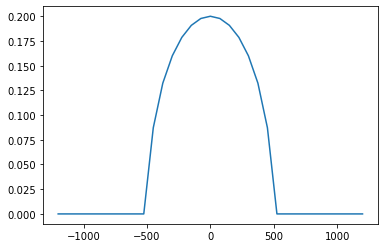

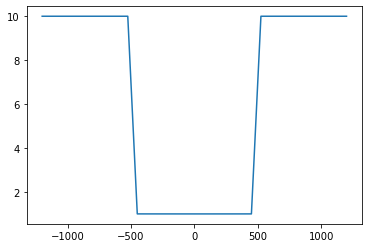

In [194]:
#Conditions initiales

x = np.arange(-L//2, L//2 + 1, deltaX)
d = 500 #largeur de la zone de glissemnt initiale

A = []
for y in x :
    if y < d and y > -d:
        A.append(np.sqrt(d**2 - y**2)*100/(d**2))
    else :
        A.append(v0)
        
B = []
for y in x :
    if y < d and y > -d:
        B.append((d**2 - np.sqrt(d**2 - y**2))/(d**2))
    else :
        B.append(10)
        
A = np.array(A)
B = np.array(B)
h = 1e-2

plt.plot(x, A)
plt.show()
plt.plot(x, B)
plt.show()

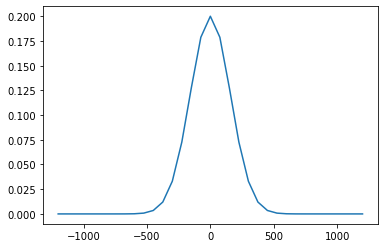

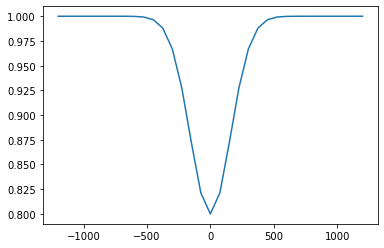

In [195]:
C = np.exp(-x**2/(d**2/5))*0.2
plt.plot(x,C)
plt.show()
D = np.ones(len(x))-C
plt.plot(x,D)
plt.show()

In [196]:
phik = np.log(A)
nuk = np.log(B)

yk = np.array([phik, nuk])

Phi = [phik]
Nu = [nuk]

for n in range(N):
    res = RKF(F, yk, h)
    yk = res[0]
    h = res[1]
    Phi.append(yk[0])
    Nu.append(yk[1])


k1=[[ 2.24577665e-06  2.33290930e-06  2.39362995e-06  2.70198418e-06
   2.85664952e-06  3.60539388e-06  3.97125373e-06  6.17590937e-06
   7.28366020e-06  2.63906539e-05 -4.06941063e-02 -3.84603622e-02
  -3.70897493e-02 -3.61682556e-02 -3.55656443e-02 -3.52213877e-02
  -3.51096318e-02 -3.52213877e-02 -3.55656443e-02 -3.61682556e-02
  -3.70897493e-02 -3.84603622e-02 -4.06941063e-02  2.63906539e-05
   7.28366020e-06  6.17590937e-06  3.97125373e-06  3.60539388e-06
   2.85664952e-06  2.70198418e-06  2.39362995e-06  2.33290930e-06
   2.24577665e-06]
 [ 9.99999990e-04  9.99999990e-04  9.99999990e-04  9.99999990e-04
   9.99999990e-04  9.99999990e-04  9.99999990e-04  9.99999990e-04
   9.99999990e-04  9.99999990e-04  9.13694562e-03  8.69037062e-03
   8.41602564e-03  8.23183542e-03  8.11123685e-03  8.04244090e-03
   8.02004008e-03  8.04244090e-03  8.11123685e-03  8.23183542e-03
   8.41602564e-03  8.69037062e-03  9.13694562e-03  9.99999990e-04
   9.99999990e-04  9.99999990e-04  9.99999990e-04  9.9

   0.00097335  0.00097335  0.00097335]]
k4=[[ 0.00013668  0.00013671  0.00013674  0.00013685  0.00013691  0.00013719
   0.00013734  0.00013814  0.00013858  0.00014547 -0.03306851 -0.03247407
  -0.0320836  -0.031809   -0.03162401 -0.03151627 -0.031481   -0.03151627
  -0.03162401 -0.031809   -0.0320836  -0.03247407 -0.03306851  0.00014547
   0.00013858  0.00013814  0.00013734  0.00013719  0.00013691  0.00013685
   0.00013674  0.00013671  0.00013668]
 [ 0.00097284  0.00097284  0.00097284  0.00097284  0.00097284  0.00097284
   0.00097284  0.00097284  0.00097284  0.00097284  0.00761315  0.00749422
   0.007416    0.00736109  0.00732404  0.0073025   0.00729543  0.0073025
   0.00732404  0.00736109  0.007416    0.00749422  0.00761315  0.00097284
   0.00097284  0.00097284  0.00097284  0.00097284  0.00097284  0.00097284
   0.00097284  0.00097284  0.00097284]]
k5=[[ 0.00013704  0.00013707  0.0001371   0.00013721  0.00013727  0.00013755
   0.0001377   0.0001385   0.00013894  0.00014581 -0.03304927 

k5=[[ 0.00026553  0.00026554  0.00026555  0.0002656   0.00026563  0.00026575
   0.00026582  0.00026617  0.00026636  0.00026934 -0.0269099  -0.02681441
  -0.02674693 -0.02669705 -0.02666246 -0.02664188 -0.02663511 -0.02664188
  -0.02666246 -0.02669705 -0.02674693 -0.02681441 -0.0269099   0.00026934
   0.00026636  0.00026617  0.00026582  0.00026575  0.00026563  0.0002656
   0.00026555  0.00026554  0.00026553]
 [ 0.00094697  0.00094697  0.00094697  0.00094697  0.00094697  0.00094697
   0.00094697  0.00094697  0.00094697  0.00094697  0.00638175  0.00636263
   0.00634907  0.0063391   0.00633215  0.00632804  0.00632668  0.00632804
   0.00633215  0.0063391   0.00634907  0.00636263  0.00638175  0.00094697
   0.00094697  0.00094697  0.00094697  0.00094697  0.00094697  0.00094697
   0.00094697  0.00094697  0.00094697]]
k6=[[ 0.00026329  0.0002633   0.00026332  0.00026337  0.00026339  0.00026352
   0.00026358  0.00026394  0.00026414  0.00026716 -0.02700506 -0.0269049
  -0.02683433 -0.02678227 -0.

k1=[[ 0.00038339  0.0003834   0.0003834   0.00038343  0.00038344  0.0003835
   0.00038354  0.00038372  0.00038382  0.00038536 -0.02242829 -0.02248096
  -0.02251238 -0.0225328  -0.02254593 -0.02255326 -0.02255566 -0.02255326
  -0.02254593 -0.0225328  -0.02251238 -0.02248096 -0.02242829  0.00038536
   0.00038382  0.00038372  0.00038354  0.0003835   0.00038344  0.00038343
   0.0003834   0.0003834   0.00038339]
 [ 0.00092336  0.00092336  0.00092336  0.00092336  0.00092336  0.00092336
   0.00092336  0.00092336  0.00092336  0.00092336  0.00548554  0.00549606
   0.00550232  0.0055064   0.00550901  0.00551048  0.00551095  0.00551048
   0.00550901  0.0055064   0.00550232  0.00549606  0.00548554  0.00092336
   0.00092336  0.00092336  0.00092336  0.00092336  0.00092336  0.00092336
   0.00092336  0.00092336  0.00092336]]
k2=[[ 0.00038445  0.00038446  0.00038447  0.00038449  0.00038451  0.00038457
   0.0003846   0.00038478  0.00038488  0.00038641 -0.02239217 -0.02244556
  -0.02247746 -0.02249823 -0

k6=[[ 0.00050572  0.00050573  0.00050573  0.00050574  0.00050575  0.00050579
   0.0005058   0.0005059   0.00050596  0.0005068  -0.01870849 -0.01880683
  -0.01886943 -0.01891236 -0.01894092 -0.01895735 -0.01896274 -0.01895735
  -0.01894092 -0.01891236 -0.01886943 -0.01880683 -0.01870849  0.0005068
   0.00050596  0.0005059   0.0005058   0.00050579  0.00050575  0.00050574
   0.00050573  0.00050573  0.00050572]
 [ 0.00089888  0.00089888  0.00089888  0.00089888  0.00089888  0.00089888
   0.00089888  0.00089888  0.00089888  0.00089888  0.00474163  0.0047613
   0.0047738   0.00478238  0.00478809  0.00479138  0.00479245  0.00479138
   0.00478809  0.00478238  0.0047738   0.0047613   0.00474163  0.00089888
   0.00089888  0.00089888  0.00089888  0.00089888  0.00089888  0.00089888
   0.00089888  0.00089888  0.00089888]]
k1=[[ 0.00050774  0.00050775  0.00050775  0.00050776  0.00050777  0.0005078
   0.00050782  0.00050792  0.00050797  0.00050881 -0.01865373 -0.01875238
  -0.0188152  -0.01885829 -0.0

k6=[[ 0.00063515  0.00063516  0.00063516  0.00063517  0.00063517  0.00063519
   0.0006352   0.00063526  0.00063529  0.00063576 -0.01555243 -0.0156564
  -0.01572333 -0.01576963 -0.01580059 -0.01581848 -0.01582435 -0.01581848
  -0.01580059 -0.01576963 -0.01572333 -0.0156564  -0.01555243  0.00063576
   0.00063529  0.00063526  0.0006352   0.00063519  0.00063517  0.00063517
   0.00063516  0.00063516  0.00063515]
 [ 0.00087298  0.00087298  0.00087298  0.00087298  0.00087298  0.00087298
   0.00087298  0.00087298  0.00087298  0.00087298  0.00411045  0.00413124
   0.00414462  0.00415388  0.00416007  0.00416364  0.00416482  0.00416364
   0.00416007  0.00415388  0.00414462  0.00413124  0.00411045  0.00087298
   0.00087298  0.00087298  0.00087298  0.00087298  0.00087298  0.00087298
   0.00087298  0.00087298  0.00087298]]
k1=[[ 0.00063706  0.00063706  0.00063706  0.00063707  0.00063707  0.00063709
   0.0006371   0.00063716  0.00063719  0.00063766 -0.01551089 -0.01561479
  -0.01568168 -0.01572796 -0

k6=[[ 0.00075375  0.00075375  0.00075376  0.00075376  0.00075376  0.00075378
   0.00075378  0.00075382  0.00075384  0.00075414 -0.01318876 -0.0132848
  -0.01334682 -0.01338984 -0.01341865 -0.01343531 -0.01344078 -0.01343531
  -0.01341865 -0.01338984 -0.01334682 -0.0132848  -0.01318876  0.00075414
   0.00075384  0.00075382  0.00075378  0.00075378  0.00075376  0.00075376
   0.00075376  0.00075375  0.00075375]
 [ 0.00084926  0.00084926  0.00084926  0.00084926  0.00084926  0.00084926
   0.00084926  0.00084926  0.00084926  0.00084926  0.00363773  0.00365693
   0.00366933  0.00367794  0.0036837   0.00368703  0.00368812  0.00368703
   0.0036837   0.00367794  0.00366933  0.00365693  0.00363773  0.00084926
   0.00084926  0.00084926  0.00084926  0.00084926  0.00084926  0.00084926
   0.00084926  0.00084926  0.00084926]]
k1=[[ 0.00075556  0.00075556  0.00075556  0.00075556  0.00075557  0.00075558
   0.00075558  0.00075562  0.00075564  0.00075594 -0.01315606 -0.01325195
  -0.01331386 -0.01335681 -0

k6=[[ 0.00086267  0.00086267  0.00086267  0.00086267  0.00086267  0.00086268
   0.00086268  0.00086271  0.00086272  0.00086293 -0.01135933 -0.01144491
  -0.01150022 -0.01153862 -0.01156434 -0.01157923 -0.01158411 -0.01157923
  -0.01156434 -0.01153862 -0.01150022 -0.01144491 -0.01135933  0.00086293
   0.00086272  0.00086271  0.00086268  0.00086268  0.00086267  0.00086267
   0.00086267  0.00086267  0.00086267]
 [ 0.00082747  0.00082747  0.00082747  0.00082747  0.00082747  0.00082747
   0.00082747  0.00082747  0.00082747  0.00082747  0.00327185  0.00328896
   0.00330002  0.0033077   0.00331285  0.00331582  0.0033168   0.00331582
   0.00331285  0.0033077   0.00330002  0.00328896  0.00327185  0.00082747
   0.00082747  0.00082747  0.00082747  0.00082747  0.00082747  0.00082747
   0.00082747  0.00082747  0.00082747]]
k1=[[ 0.00086438  0.00086438  0.00086438  0.00086438  0.00086438  0.00086439
   0.0008644   0.00086442  0.00086443  0.00086464 -0.0113328  -0.01141821
  -0.01147341 -0.01151173 -

k2=[[ 0.00098476  0.00098476  0.00098476  0.00098476  0.00098476  0.00098477
   0.00098477  0.00098479  0.0009848   0.00098494 -0.00961272 -0.00968626
  -0.00973379 -0.0097668  -0.00978891 -0.00980171 -0.00980591 -0.00980171
  -0.00978891 -0.0097668  -0.00973379 -0.00968626 -0.00961272  0.00098494
   0.0009848   0.00098479  0.00098477  0.00098477  0.00098476  0.00098476
   0.00098476  0.00098476  0.00098476]
 [ 0.00080305  0.00080305  0.00080305  0.00080305  0.00080305  0.00080305
   0.00080305  0.00080305  0.00080305  0.00080305  0.00292253  0.00293724
   0.00294674  0.00295334  0.00295777  0.00296033  0.00296117  0.00296033
   0.00295777  0.00295334  0.00294674  0.00293724  0.00292253  0.00080305
   0.00080305  0.00080305  0.00080305  0.00080305  0.00080305  0.00080305
   0.00080305  0.00080305  0.00080305]]
k3=[[ 0.00098516  0.00098516  0.00098516  0.00098517  0.00098517  0.00098517
   0.00098518  0.00098519  0.0009852   0.00098534 -0.00960742 -0.00968091
  -0.00972842 -0.00976141 -

   0.00078478  0.00078478  0.00078478]]
k3=[[ 0.00107652  0.00107652  0.00107652  0.00107652  0.00107653  0.00107653
   0.00107653  0.00107654  0.00107655  0.00107666 -0.00847114 -0.00853624
  -0.00857831 -0.00860752 -0.0086271  -0.00863842 -0.00864214 -0.00863842
  -0.0086271  -0.00860752 -0.00857831 -0.00853624 -0.00847114  0.00107666
   0.00107655  0.00107654  0.00107653  0.00107653  0.00107653  0.00107652
   0.00107652  0.00107652  0.00107652]
 [ 0.0007847   0.0007847   0.0007847   0.0007847   0.0007847   0.0007847
   0.0007847   0.0007847   0.0007847   0.0007847   0.00269422  0.00270724
   0.00271565  0.00272149  0.00272541  0.00272767  0.00272842  0.00272767
   0.00272541  0.00272149  0.00271565  0.00270724  0.00269422  0.0007847
   0.0007847   0.0007847   0.0007847   0.0007847   0.0007847   0.0007847
   0.0007847   0.0007847   0.0007847 ]]
k4=[[ 0.00107821  0.00107821  0.00107821  0.00107821  0.00107821  0.00107822
   0.00107822  0.00107823  0.00107824  0.00107834 -0.00845135 -0

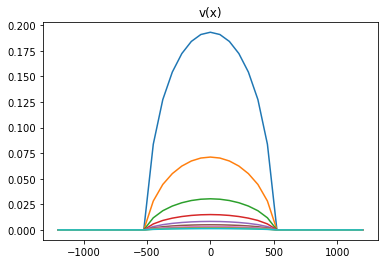

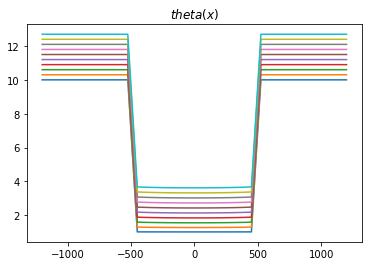

In [197]:
#Affichage

for n in range(1, N, 30):
    plt.plot(x, np.exp(Phi[n]))
plt.title('v(x)')
plt.show()

for n in range(1, N, 30):
    plt.plot(x, np.exp(Nu[n]))
plt.title('$theta(x)$')
plt.show()